In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os
import ast
import warnings
from tqdm import tqdm
import re
import random

import warnings
from dataclasses import replace

warnings.filterwarnings("ignore")
random.seed(42)

In [2]:
from variables.variables import *

from variables.configs import final_configs
from variables.labels import *

from scripts.plot import *
from scripts.helpers import run_experiment
from scripts.propensity import get_propensity_scores

### Re-Generate Results with Selected Parameters and save tables

Extracts config from configs file and re-generates results with selected config for each variable. Dataframes with ATE and ASMD are saved, plot are generated. 

In [3]:
REGENERATE_RESULTS = False

ps_dataframes = {}
if REGENERATE_RESULTS:
    feature_values = {}
    for exposure, config in tqdm(EXPOSURES.items()):
    #for exposure, params in final_configs.items():
        params = final_configs[exposure]
        cfg = replace(
            BASE_CONFIG,
            clip=params['clip'],
            q=params['q'],
            method=config['method'],
            limit=config['cutoff'],
        )
        #print(cfg.__dict__['n_features'])
        title = exposure.split('_target_day')[0]
        df, kwargs, X, shap_values = get_propensity_scores(
            exposure=exposure,
            config=cfg.__dict__,
            variables=variable_config,
            file=DATAFRAME_PATH,
        )
        ps_dataframes[title] = df
        
        current_flag = run_experiment(
            config=cfg.__dict__,
            variable_config=variable_config,
            df=df,
            kwargs=kwargs,
            X=X,
            shap_values=shap_values,
            save_results=True,
            log_experiment=False,
        )
        
    treatment_distributions = summarize_ps_dataframes_6cols(ps_dataframes, diet_definitions)
    treatment_distributions.to_csv(f"{paper_tables_folder}/treatment_distributions.csv")
    #treatment_distributions
    
    feature_values = {}
    for title, df in ps_dataframes.items():
        exposure = f"{title}_target_day"
        feature_values[title] = {
            'treated' : list(df[df['treated'] == 1][exposure]),
            'control' : list(df[df['treated'] == 0][exposure]),
        }
        
    # Example usage:
    fig, axes = plot_test_control_distributions(feature_values, rdis=rdis, labels=diet_short_names_mapping)
    plt.show()

### Extraction

In [4]:
import os
import pandas as pd
from statsmodels.stats.multitest import multipletests

def load_dataframes(
        folder_path=df_folder_path,
        type='results',
    ):
    dfs = {}

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # CSV
        if filename.lower().endswith(".csv"):
            if '_ate' in filename.lower():
                if type == 'results':
                    df_name = filename.replace(".csv", "").replace("_ate", "")
                    df = pd.read_csv(file_path).set_index('outcome').loc[variable_config['sleep_targets']]
                    df['p_value_boot_abs_uncorrected'] = df['p_value_boot_abs']
                    df['p_value_boot_abs'] = multipletests(
                        list(df['p_value_boot_abs']),
                        alpha=0.05,
                        method="fdr_bh",
                        maxiter=1,
                        is_sorted=False,
                        returnsorted=False,
                    )[1]
                    df['is_significant_abs'] = [bool(p <= 0.05) for p in df['p_value_boot_abs']]
                    dfs[df_name] = df
                elif type == 'quality':
                    df_name = filename.replace(".csv", "").replace("_ate", "")
                    dfs[df_name] = pd.read_csv(file_path).set_index('outcome')
            elif type == 'asmd':
                df_name = filename.replace(".csv", "").replace("_asmd", "")
                temp = pd.read_csv(file_path).dropna()
                temp = temp.rename(columns={'feature': 'outcome'})
                dfs[df_name] = temp.set_index('outcome').dropna()
    return dfs

# Example usage
results = load_dataframes()
control = load_dataframes(type='quality')
asmd = load_dataframes(type='asmd')

print(f"Loaded {len(results)} dataframes")

Loaded 27 dataframes


### Quality Report

In [5]:
summary = summarize_runs(
    control,
    asmd,
    variable_config,
    outcome_col="outcome",
    labels=diet_short_names_mapping,
)

summary.to_csv(f"{paper_tables_folder}/quality_report.csv")
summary.style.bar(color="#ededed")

,% confounders with ASMD<0.1,% direct confounders with ASMD<0.05,% structural confounders with ASMD<0.05,% negative targets significant,max ASMD (confounders),mean ASMD (confounders)
dietary exposure,,,,,,
caffeine_late_mg,100.000000,100.000000,100.000000,0.000000,0.037654,0.020031
Last-meal–to-bedtime interval (h),100.000000,100.000000,100.000000,0.000000,0.044509,0.020953
Animal-based foods (% of daily energy),100.000000,100.000000,100.000000,0.000000,0.045215,0.026620
Zinc (mg),100.000000,100.000000,100.000000,0.000000,0.045395,0.022124
Meat and poultry (% of daily energy),100.000000,100.000000,100.000000,0.000000,0.045769,0.015638
Processed foods (% of daily energy),100.000000,100.000000,100.000000,0.000000,0.045805,0.016464
Dairy (% of daily energy),100.000000,100.000000,100.000000,0.000000,0.046258,0.024641
Vitamin D (mcg),100.000000,100.000000,100.000000,0.000000,0.046415,0.017298
Dinner energy (%),100.000000,100.000000,100.000000,0.000000,0.046482,0.016697


### Figure 2 (heatmap)


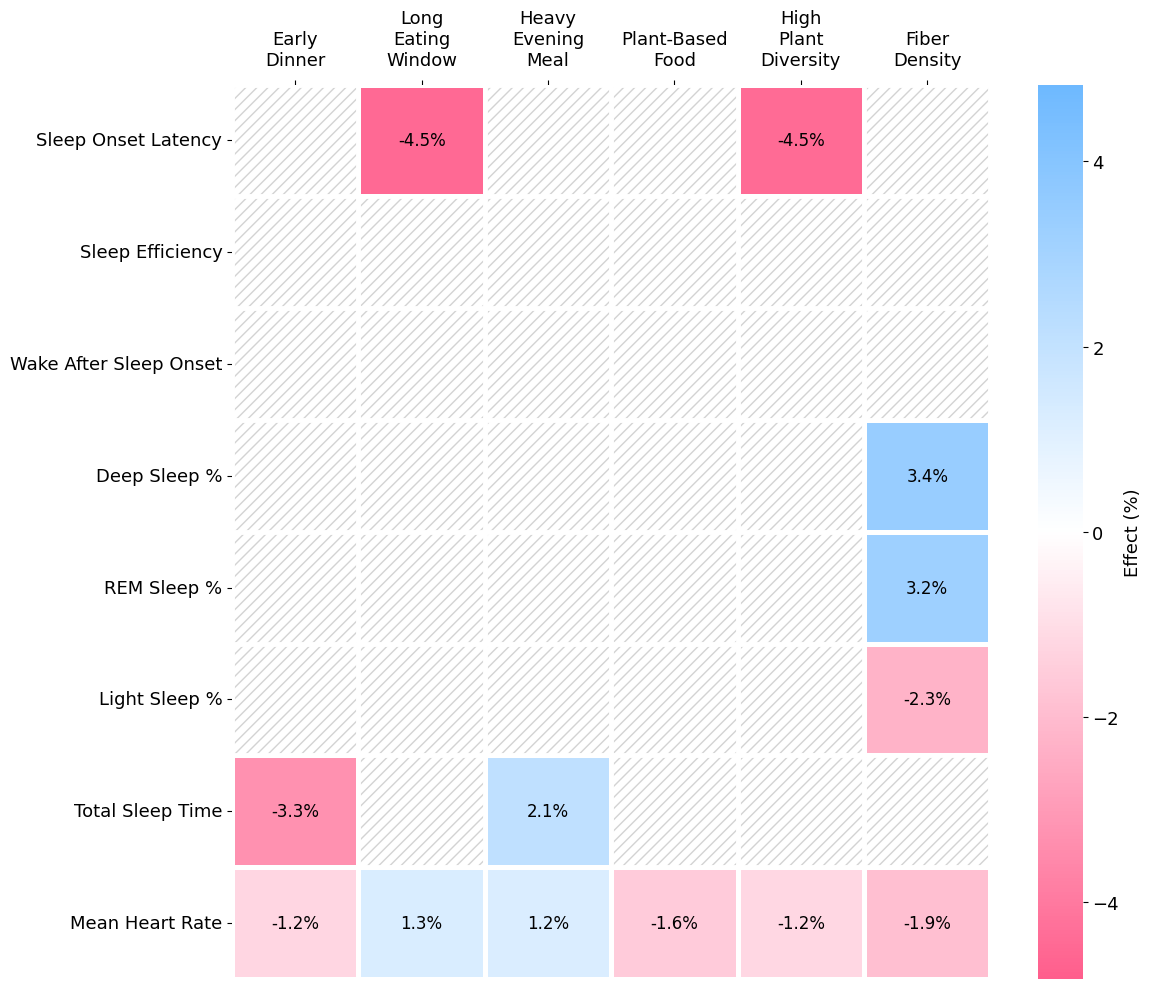

In [6]:
results_tmp = {k : v for k, v in results.items() if results[k]['is_significant_abs'].max() == True}
heatmap_effects_generic(
    list(results_tmp.values()),
    list(results_tmp.keys()),
    figsize=(12, 10),
    labels_dict=labels_dict,
    x_labels=diet_short_names_mapping,
)

### Main figures

In [7]:
meal_timing_features = ['night_calories_pct', 'hours_to_sleep', 'eating_window_h']
plant_based_features = ['unique_plant_based_foods_count', 'fiber_density_energy', 'plant_based_whole_foods_ratio']

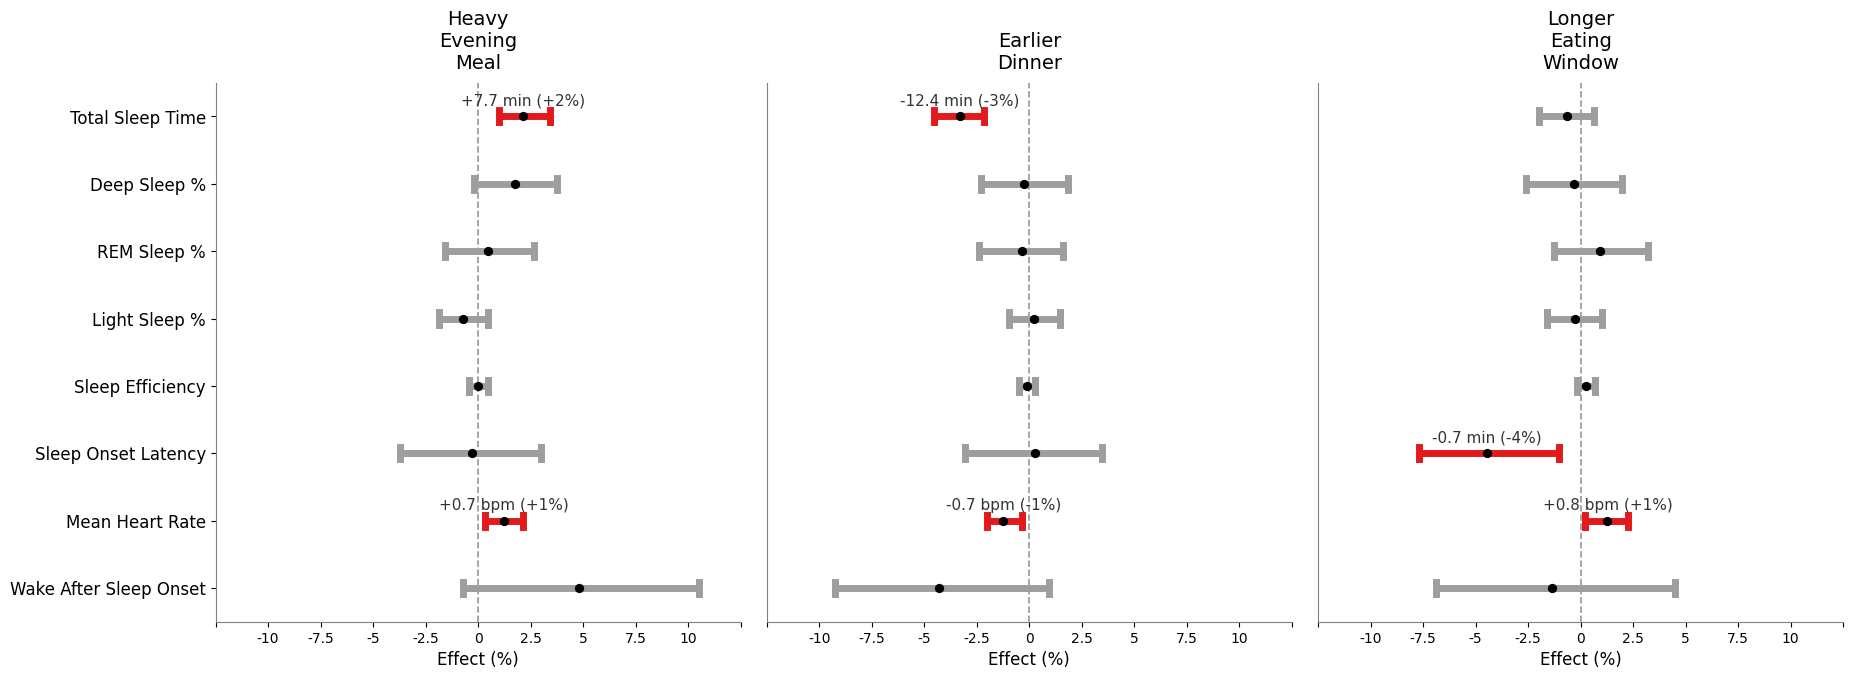

In [8]:
to_plot = meal_timing_features

results_tmp = {k : v for k, v in results.items() if k in to_plot}
results_renamed = {diet_full_names_mapping[k] : v for k, v in results_tmp.items()}

fig, ax = plot_outcome_effects_panels_significant(
    
    dfs=results_renamed.values(),
    df_labels=results_renamed.keys(),
    labels_dict=labels_dict,
    annotation_dict=annotation_dict,
    
    figsize_per_panel=(7, 7),
    x_label = "Effect (%)",
    ci_line_width = 5,
    p_fontsize = 11,
    panels_per_row= 4,
)
plt.show()

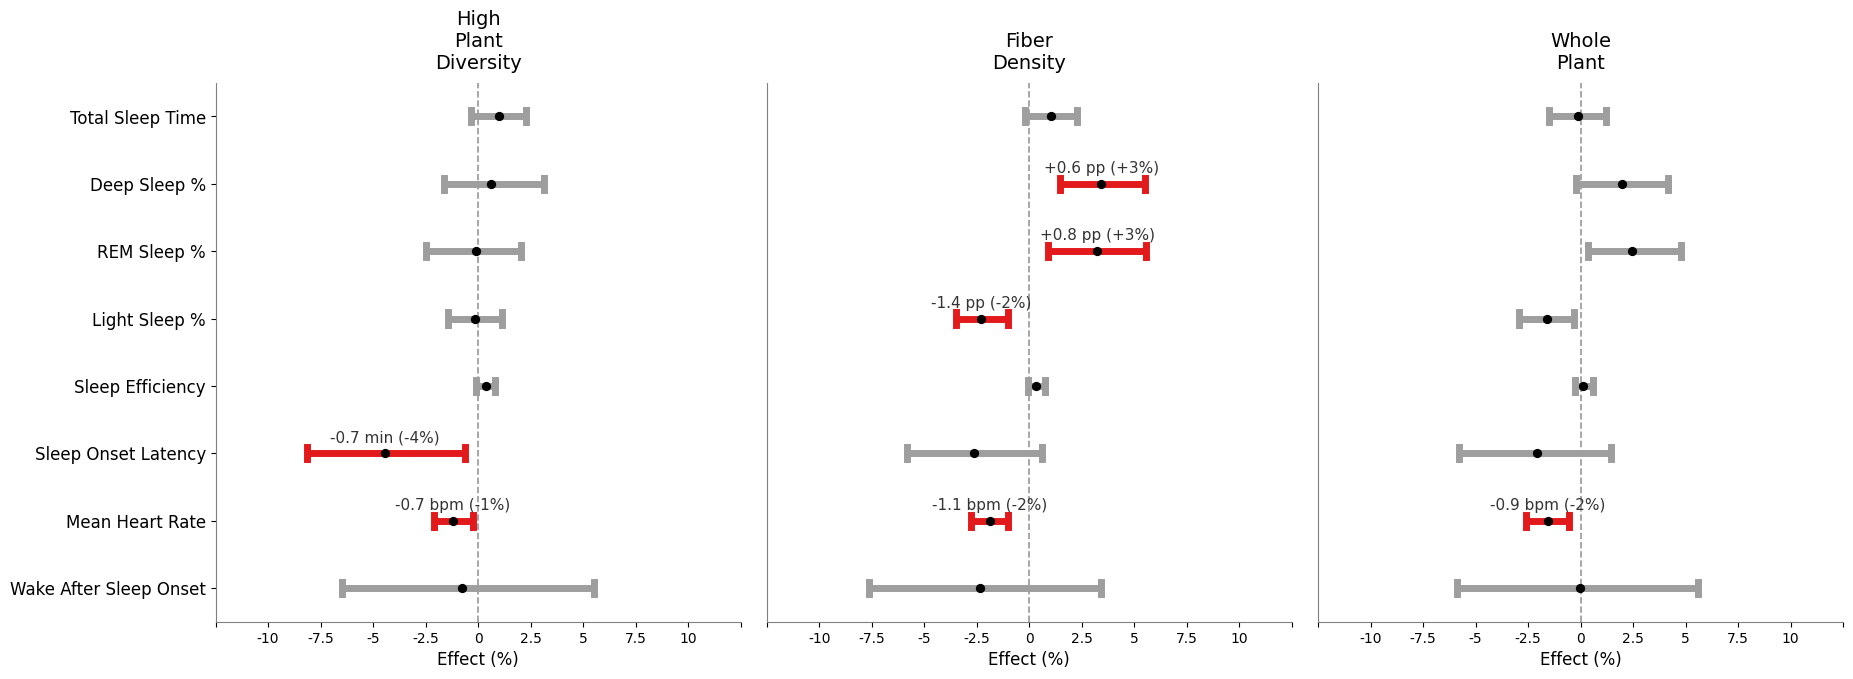

In [9]:
to_plot = plant_based_features

results_tmp = {k : v for k, v in results.items() if k in to_plot}
results_renamed = {diet_full_names_mapping[k] : v for k, v in results_tmp.items()}

fig, ax = plot_outcome_effects_panels_significant(
    
    dfs=results_renamed.values(),
    df_labels=results_renamed.keys(),
    labels_dict=labels_dict,
    annotation_dict=annotation_dict,
    
    figsize_per_panel=(7, 7),
    x_label = "Effect (%)",
    ci_line_width = 5,
    p_fontsize = 11,
    panels_per_row= 4,
)
plt.show()

### Same plot

In [14]:
vit_plants = [
    'magnesium_mg',
    'vitamin_c',
    'folate',
    'vitamin_e',
]

vit_aminal = [
    'vitamin_d_ug',
    'vitamin_b6_mg', 
    'vitamin_b12_ug', 
]

vit_mixed = [
    'omega3_total_g',
    'zinc_mg', 
    'calcium_mg', 
]

macros = [
    'prot_pct',
    'fat_pct',
    'carb_pct',
]

composition_processed = [
    'processed_categories_ratio', 
    'meat_and_poultry_energy_ratio', 
    'animal_based_whole_foods_ratio',
    'sat_fat_g', 
]

composition_whole = [
    'furits_and_veggies_energy_ratio', 
    'plant_based_whole_foods_ratio',
    'whole_food_categories_ratio', 
    'whole_dairy_categories_ratio',
]

coffee = [
    'caffeine_late_mg',
]

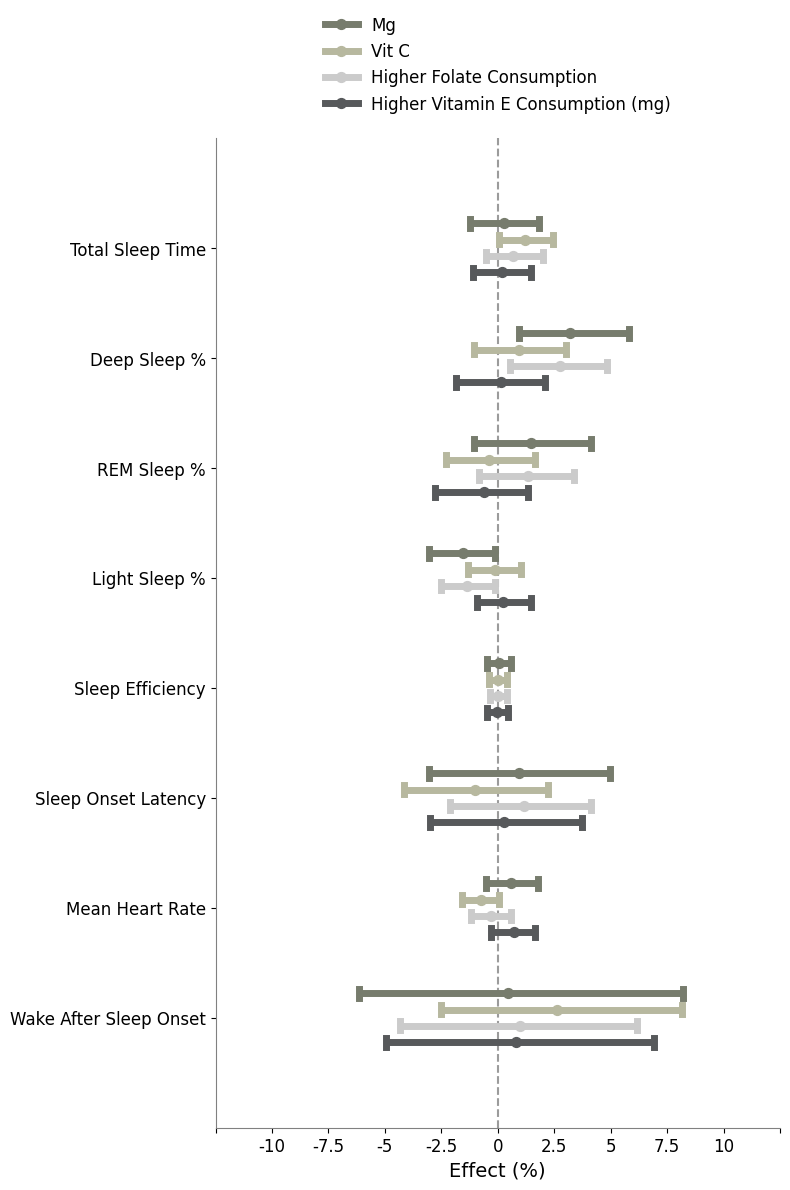

In [17]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=vit_plants,
    exposure_labels=diet_full_names_mapping,  # renames legend entries
    labels_dict=labels_dict,                  # renames outcome y-ticks
    figsize_per_panel=(8, 12),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()

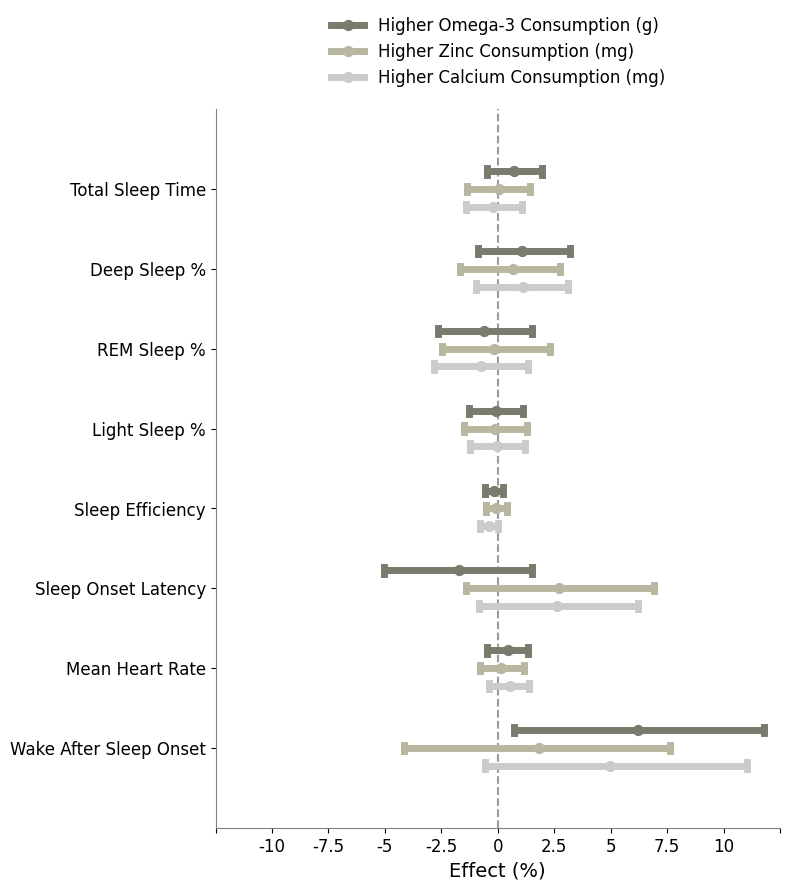

In [12]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=vit_mixed,
    exposure_labels=diet_full_names_mapping,  # renames legend entries
    labels_dict=labels_dict,                  # renames outcome y-ticks
    figsize_per_panel=(8, 9),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()

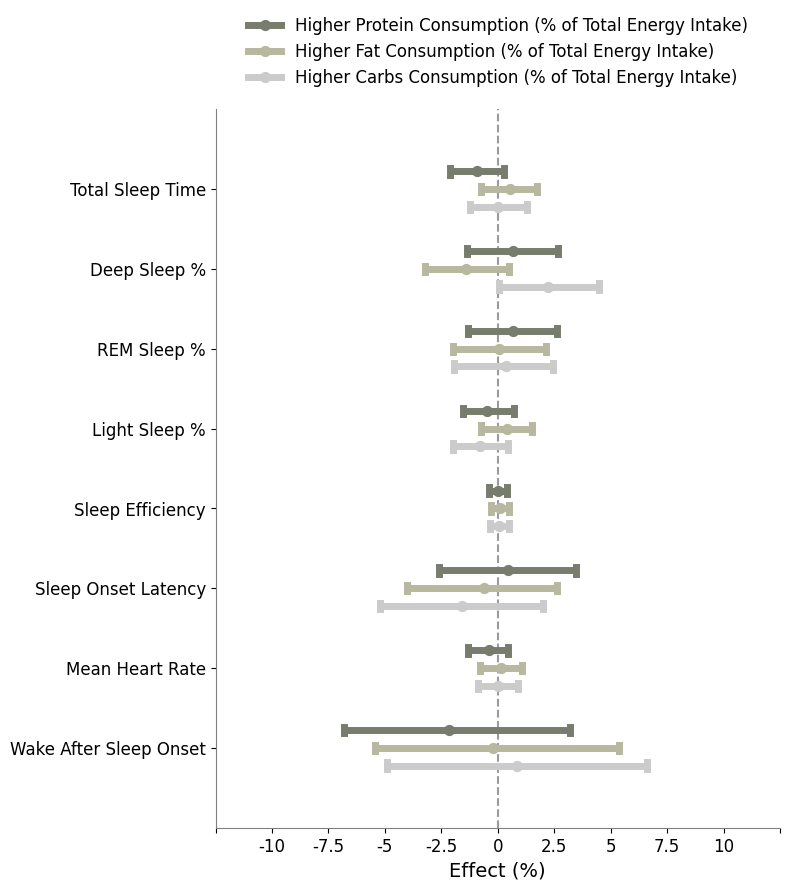

In [13]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=macros,
    exposure_labels=diet_full_names_mapping,  # renames legend entries
    labels_dict=labels_dict,                  # renames outcome y-ticks
    figsize_per_panel=(8, 9),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()

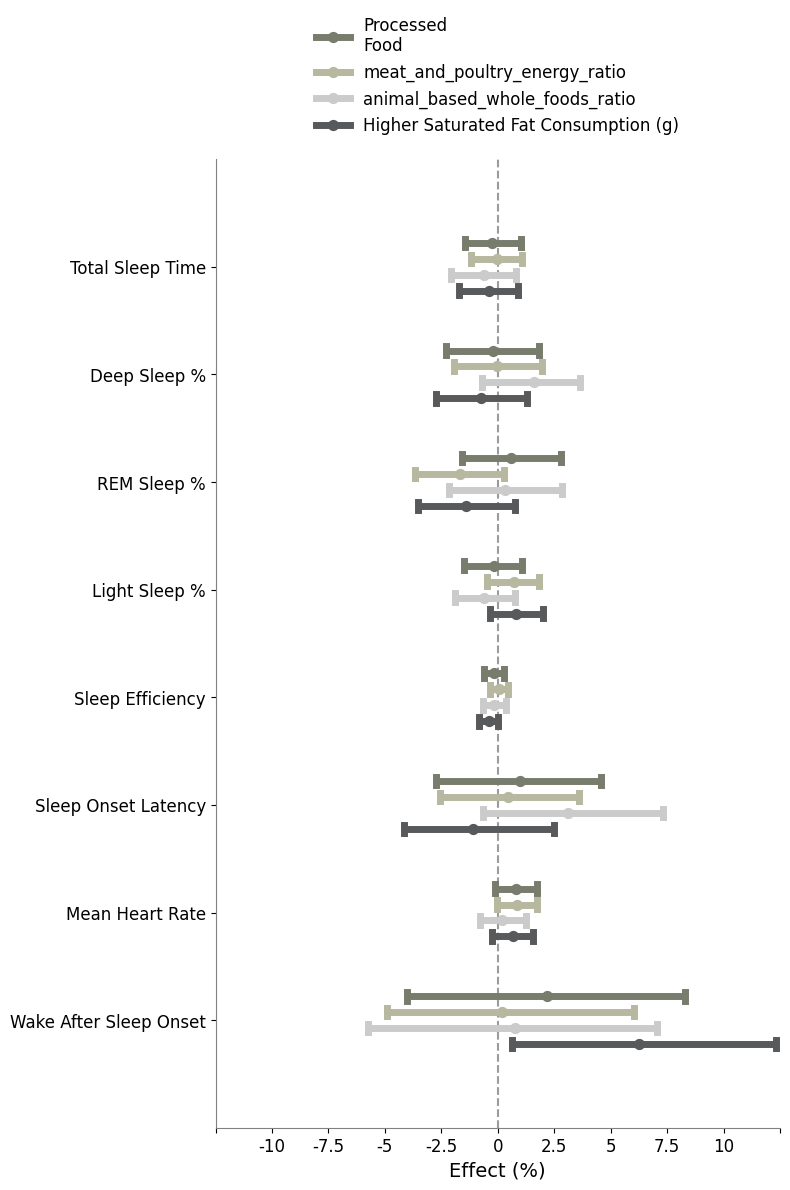

In [14]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=composition_processed,
    exposure_labels=diet_full_names_mapping,  # renames legend entries
    labels_dict=labels_dict,                  # renames outcome y-ticks
    figsize_per_panel=(8, 12),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()

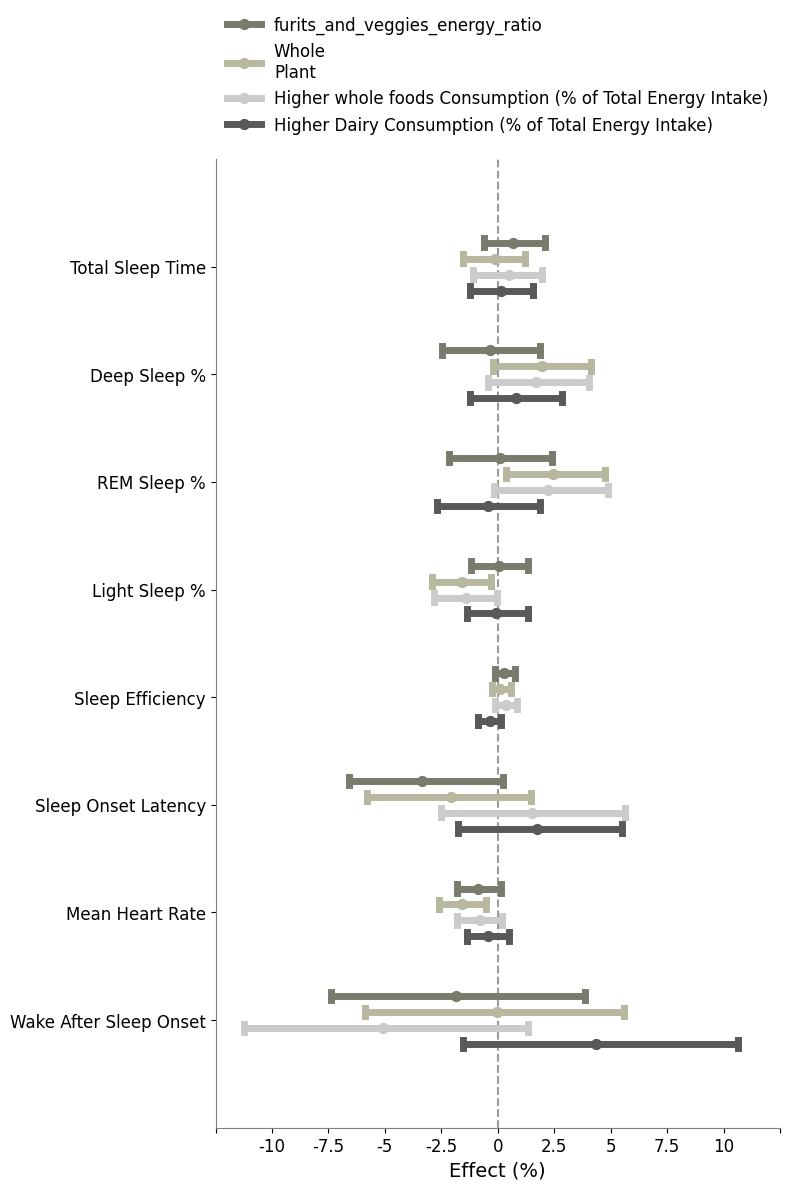

In [15]:
fig, ax = plot_outcome_effects_panels(
    results=results,
    to_plot=composition_whole,
    exposure_labels=diet_full_names_mapping,  # renames legend entries
    labels_dict=labels_dict,                  # renames outcome y-ticks
    figsize_per_panel=(8, 12),
    x_label="Effect (%)",
    ci_line_width=5,
    p_fontsize=11,
)
plt.show()